### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import os
from datetime import datetime

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
# Debug print flag 

DEBUG = False

#### Tracking the state-action pairs for checking convergence


In [4]:
def initialise_tracking_states():
#     sample_q_values = [('1-14-1', '2-5'), ('1-14-1', '2-4'), ('1-14-1', '0-1'), ('1-14-1', '4-5'), ('1-14-1', '3-4'), ('1-14-1', '1-2'), ('1-14-1', '2-3')]    
    sample_q_values = [ ('1-20-6', '0-1'),
                        ('1-20-6', '0-2'),
                        ('1-20-6', '0-3'),
                        ('1-20-6', '0-4'),
                        ('1-20-6', '1-0'),
                        ('1-20-6', '1-2'),
                        ('1-20-6', '1-3'),
                        ('1-20-6', '1-4'),
                        ('1-20-6', '4-1'),
                        ('1-20-6', '4-2'),
                        ('1-20-6', '4-3'),
                        ('1-20-6', '0-0'),
                        ('1-20-6', '0-1'),
                        ('1-20-6', '0-2'),
                        ('1-5-5', '1-0'),
                        ('1-5-5', '1-2'),
                        ('1-5-5', '1-3'),
                        ('1-5-5', '1-4'),
                        ('1-5-5', '2-0'),
                        ('1-5-5', '2-1'),
                        ('1-5-5', '2-3'),
                        ('1-5-5', '2-4'),
                        ('1-5-5', '3-0'),
                        ('1-5-5', '3-1'),
                        ('1-5-5', '3-2'),
                        ('1-5-5', '3-4'),
                        ('1-5-5', '4-0'),
                        ('1-5-5', '4-1'),
                        ('1-5-5', '4-2'),
                        ('1-5-5', '4-3')]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []

In [5]:
def save_tracking_states(curr_state, curr_action, q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(q_value)

In [6]:
def to_string(state_or_action):
    return ('-'.join(str(e) for e in state_or_action))

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, action_space):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = action_space

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.00065 #0.999
        self.epsilon_min = 0
        
        self.batch_size = 32    
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        # model.summary() 
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_epsilon(self, time):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)

    def get_action(self, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       

        epsilon = self.get_epsilon(time)

        possible_actions_index, all_possible_actions = env.requests(state)

        if len(possible_actions_index) == 0:
            return all_possible_actions[0]

        if (np.random.rand() <= epsilon):
            return random.choice(all_possible_actions)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            state = env.state_encod_arch1(state)
            state = state.reshape(1, self.state_size)
            q_values = self.model.predict(state)[0]
            
            argmax = np.argmax(q_values[possible_actions_index])
#             DEBUG and print(f'q_values: {q_values}, available_q_vals: {q_values[possible_actions_index]}, argmax: {argmax}, all_possible_actions: {all_possible_actions}')
            return all_possible_actions[argmax]

    def append_sample(self, state, action, reward, next_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state))
    
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards = [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                # Write your code from here
                # 1. Predict the target from earlier model
                update_input[i] = env.state_encod_arch1(state).reshape(1, self.state_size)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state).reshape(1, self.state_size)                
                
            # 2. Get the target for the Q-network
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                # if done[i]:
                #     target[i][actions[i]] = rewards[i]
                # else: # non-terminal state
                action_idx = action_space.index(actions[i])
                target[i][action_idx] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [9]:
Episodes = 1000

env = CabDriver()
action_space, state_space, state = env.reset()
action_size = len(action_space)
state_size = len(env.state_encod_arch1(state_space[0]))

agent = DQNAgent(state_size, action_size, action_space)

States_track = collections.defaultdict(dict)
initialise_tracking_states()

# create folder with current time stamp
DIR_NAME = os.path.join(
        os.getcwd(), 
        'model-' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(DIR_NAME)

agent.epsilon_decay = 65.0/(Episodes * 10)
print(agent.epsilon_decay)

scores = []

start_time = time.time()






0.0065


### DQN block

In [10]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent

    day = 0
    score = 0
    terminal_state = False

    # reset the state before new episode
    _, _, state = env.reset()
    initial_state = state
        
    while not terminal_state:        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        
        action_start_time = time.time()
        action = agent.get_action(state, episode)
        DEBUG and print("Action time:",  time.time() -  action_start_time)
        
        # 2. Evaluate your reward and next state
        step_start_time = time.time()
        next_state, reward = env.step(state, action, Time_matrix)
        DEBUG and print("Step time:",  time.time() -  step_start_time)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state)
        
        # 4. Train the model by calling function agent.train_model
        train_start_time = time.time()
        agent.train_model()
        DEBUG and print("Train time:",  time.time() -  train_start_time)
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        scores.append(score)
        
        # increase the date if the day is changed
        if next_state[2] != state[2]:
            day = day + 1
        
        DEBUG and print(f'state: {state}, action: {action}, next_state: {next_state}, reward: {reward}, day: {day}')

        if day > 30:
            terminal_state = True
            
        if (episode % 1000 == 0):
            agent.save(DIR_NAME + '\\' + str(episode) + '.h5')
        
        state = next_state

    print(f'Score {episode}: {score}')
    
    # for tracking
    
    tracking_start_time = time.time()
    state_enc = env.state_encod_arch1(initial_state)
    state_enc = np.reshape(state_enc, [1, 36])
    q_values = agent.get_q_values(state_enc)
    
    state_string = to_string(initial_state)
    
    for index in range(len(env.action_space)):
        action_string = to_string(env.action_space[index])
        save_tracking_states(state_string, action_string, q_values[index])
    
    DEBUG and print("Tracking time:",  time.time() -  tracking_start_time) 
    

elapsed_time = time.time() - start_time
print(f'Entire Operation took {elapsed_time} seconds')



Score 0: -147.0
Score 1: -262.0
Score 2: -164.0
Score 3: 219.0
Score 4: -154.0
Score 5: -399.0
Score 6: -150.0
Score 7: -106.0
Score 8: 39.0
Score 9: -91.0
Score 10: -222.0
Score 11: -442.0
Score 12: -276.0
Score 13: -91.0
Score 14: -47.0
Score 15: 35.0
Score 16: -56.0
Score 17: -102.0
Score 18: 128.0
Score 19: -272.0
Score 20: -206.0
Score 21: 17.0
Score 22: -37.0
Score 23: -40.0
Score 24: 13.0
Score 25: -190.0
Score 26: 35.0
Score 27: -60.0
Score 28: 168.0
Score 29: 196.0
Score 30: 460.0
Score 31: 290.0
Score 32: 133.0
Score 33: -9.0
Score 34: 230.0
Score 35: -22.0
Score 36: -55.0
Score 37: 287.0
Score 38: 90.0
Score 39: -126.0
Score 40: 417.0
Score 41: -141.0
Score 42: -75.0
Score 43: 179.0
Score 44: 100.0
Score 45: 260.0
Score 46: 326.0
Score 47: 350.0
Score 48: 143.0
Score 49: -137.0
Score 50: 25.0
Score 51: -24.0
Score 52: -145.0
Score 53: 20.0
Score 54: 143.0
Score 55: -178.0
Score 56: 167.0
Score 57: 323.0
Score 58: 141.0
Score 59: -117.0
Score 60: 449.0
Score 61: 505.0
Score

Score 452: 1517.0
Score 453: 1617.0
Score 454: 1083.0
Score 455: 1518.0
Score 456: 1531.0
Score 457: 1412.0
Score 458: 1424.0
Score 459: 1448.0
Score 460: 1555.0
Score 461: 1457.0
Score 462: 1016.0
Score 463: 1591.0
Score 464: 1591.0
Score 465: 1392.0
Score 466: 1512.0
Score 467: 1491.0
Score 468: 1479.0
Score 469: 1464.0
Score 470: 1560.0
Score 471: 1339.0
Score 472: 1583.0
Score 473: 1187.0
Score 474: 1502.0
Score 475: 935.0
Score 476: 1236.0
Score 477: 1611.0
Score 478: 1274.0
Score 479: 1413.0
Score 480: 1177.0
Score 481: 1424.0
Score 482: 1358.0
Score 483: 1398.0
Score 484: 1193.0
Score 485: 1187.0
Score 486: 1388.0
Score 487: 1645.0
Score 488: 1018.0
Score 489: 1305.0
Score 490: 1270.0
Score 491: 1738.0
Score 492: 1788.0
Score 493: 1474.0
Score 494: 1400.0
Score 495: 1235.0
Score 496: 1340.0
Score 497: 1620.0
Score 498: 1144.0
Score 499: 1088.0
Score 500: 1437.0
Score 501: 1274.0
Score 502: 1328.0
Score 503: 1334.0
Score 504: 1653.0
Score 505: 1603.0
Score 506: 1415.0
Score 507: 

Score 908: 1440.0
Score 909: 1515.0
Score 910: 1369.0
Score 911: 1682.0
Score 912: 1443.0
Score 913: 1359.0
Score 914: 1334.0
Score 915: 1275.0
Score 916: 1862.0
Score 917: 1718.0
Score 918: 1497.0
Score 919: 1348.0
Score 920: 1612.0
Score 921: 1382.0
Score 922: 1607.0
Score 923: 1340.0
Score 924: 1364.0
Score 925: 1277.0
Score 926: 1783.0
Score 927: 1326.0
Score 928: 1428.0
Score 929: 1706.0
Score 930: 1686.0
Score 931: 1490.0
Score 932: 1736.0
Score 933: 1358.0
Score 934: 1369.0
Score 935: 1487.0
Score 936: 1754.0
Score 937: 1461.0
Score 938: 1295.0
Score 939: 1529.0
Score 940: 1599.0
Score 941: 1277.0
Score 942: 1616.0
Score 943: 1394.0
Score 944: 1388.0
Score 945: 1662.0
Score 946: 1454.0
Score 947: 1308.0
Score 948: 1973.0
Score 949: 1434.0
Score 950: 1501.0
Score 951: 1713.0
Score 952: 1623.0
Score 953: 1585.0
Score 954: 1335.0
Score 955: 1286.0
Score 956: 1603.0
Score 957: 1788.0
Score 958: 1601.0
Score 959: 1719.0
Score 960: 1668.0
Score 961: 1769.0
Score 962: 1202.0
Score 963:

In [11]:
print(scores)

[-35.0, -40.0, -45.0, -54.0, -38.0, -40.0, -16.0, -12.0, -19.0, -5.0, 12.0, 42.0, 17.0, 21.0, 10.0, -7.0, -18.0, -23.0, -20.0, -8.0, -13.0, 11.0, 19.0, 15.0, 27.0, 35.0, 22.0, 26.0, 21.0, 29.0, 24.0, 19.0, 6.0, 1.0, -26.0, -10.0, 2.0, 18.0, 34.0, 21.0, 16.0, 11.0, -1.0, 3.0, 3.0, 11.0, 21.0, 19.0, 31.0, 15.0, 24.0, 19.0, -4.0, -10.0, -10.0, -45.0, -41.0, -22.0, -3.0, 2.0, -16.0, -8.0, -8.0, -20.0, -19.0, 21.0, -14.0, -6.0, -11.0, -16.0, -16.0, 8.0, 2.0, -4.0, -9.0, -14.0, -17.0, -12.0, -14.0, -32.0, -34.0, -39.0, -44.0, -49.0, -45.0, -38.0, -43.0, -39.0, -50.0, -55.0, -48.0, -49.0, -51.0, -56.0, -72.0, -52.0, -57.0, -43.0, -59.0, -59.0, -56.0, -61.0, -56.0, -61.0, -66.0, -54.0, -70.0, -34.0, -62.0, -67.0, -72.0, -73.0, -78.0, -83.0, -89.0, -94.0, -92.0, -99.0, -105.0, -82.0, -84.0, -85.0, -120.0, -125.0, -139.0, -119.0, -124.0, -145.0, -150.0, -155.0, -160.0, -165.0, -170.0, -171.0, -163.0, -168.0, -173.0, -191.0, -202.0, -200.0, -189.0, -166.0, -185.0, -182.0, -194.0, -199.0, -167.0, 

### Tracking Convergence

In [12]:
States_track

defaultdict(dict,
            {'1-20-6': {'0-1': [],
              '0-2': [],
              '0-3': [],
              '0-4': [],
              '1-0': [],
              '1-2': [],
              '1-3': [],
              '1-4': [],
              '4-1': [],
              '4-2': [],
              '4-3': [],
              '0-0': []},
             '1-5-5': {'1-0': [],
              '1-2': [],
              '1-3': [],
              '1-4': [],
              '2-0': [],
              '2-1': [],
              '2-3': [],
              '2-4': [],
              '3-0': [],
              '3-1': [],
              '3-2': [],
              '3-4': [],
              '4-0': [],
              '4-1': [],
              '4-2': [],
              '4-3': []}})

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

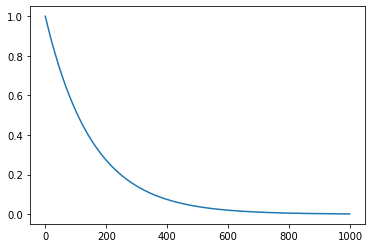

In [13]:
# time_arr = np.arange(0,1000)
epsilon = []
for i in range(0,Episodes):
#     epsilon.append(0 + (1 - 0) * np.exp(-0.0065*i))
    epsilon.append(agent.get_epsilon(i))

plt.plot(np.arange(0,Episodes), epsilon)
plt.show()